In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Use ensemble to train the model
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import lightgbm as lgb
import sys
import sys

# In the second part of the notebook
from sklearn.preprocessing import LabelEncoder

# This part of importing would be moved to main.py or train.py later
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from scipy.stats import zscore
from scipy.special import boxcox1p

import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
# from catboost import CatBoostRegressor

import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import wandb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import argparse

In [3]:
def parse_option():
    parse = argparse.ArgumentParser("Zindi Competition", add_help=False)
    parse.add_argument('--num_leaves', type=int, help="number of leaves in the tree model", default=31)
    parse.add_argument('--max_depth', type=int, help="maximum depth of the tree model", default=-1)
    parse.add_argument('--learning_rate', type=float, help="learning rate of the tree model", default=0.1)
    parse.add_argument('--n_estimators', type=int, help="number of trees in the tree model", default=100)
    parse.add_argument('--min_child_weight', type=float, help="minimum sum of instance weight (hessian) needed in a child (leaf)", default=1e-3)
    parse.add_argument('--subsample', type=float, help="subsample ratio of the training instance", default=1.0)
    parse.add_argument('--colsample_bytree', type=float, help="subsample ratio of columns when constructing each tree", default=1.0)
    parse.add_argument('--reg_alpha', type=float, help="L1 regularization term on weights", default=0.0)
    parse.add_argument('--reg_lambda', type=float, help="L2 regularization term on weights", default=0.0)
    parse.add_argument('--min_split_gain', type=float, help="minimum loss reduction required to make a further partition on a leaf node of the tree", default=0.0)
    parse.add_argument('--min_child_samples', type=int, help="minimum number of data needed in a child (leaf)", default=20)
    parse.add_argument('--num_iterations', type=int, help="number of boosting iterations", default=100)
    parse.add_argument('--early_stopping_round', type=int, help="number of rounds without improvements before stopping", default=10)
    parse.add_argument('--seed', type=int, help="seed for training", default=42)
    parse.add_argument('--verbose', type=int, help="verbose", default=1)
    parse.add_argument('--device', type=str, help="device to use for training", default='cpu')
    parse.add_argument('--num_folds', type=int, help="number of folds for cross validation", default=5)
    parse.add_argument('--wandb', action='store_true', help="log to wandb")
    parse.add_argument('--wandb_project', type=str, help="wandb project name")
    parse.add_argument('--wandb_entity', type=str, help="wandb entity name")
    parse.add_argument('--wandb_run_name', type=str, help="wandb run name")
    parse.add_argument('--wandb_tags', type=str, help="wandb tags")
    parse.add_argument('--wandb_group', type=str, help="wandb group")
    parse.add_argument('--wandb_job_type', type=str, help="wandb job type")
    parse.add_argument('--wandb_config', type=str, help="wandb config")
    parse.add_argument('--wandb_dir', type=str, help="wandb directory")
    parse.add_argument('--wandb_save_model', action='store_true', help="save model to wandb")
    parse.add_argument('--wandb_save_model_path', type=str, help="wandb save model path")
    parse.add_argument('--wandb_save_model_name', type=str, help="wandb save model name")
    parse.add_argument('--wandb_save_model_method', type=str, help="wandb save model method")
    parse.add_argument('--wandb_save_model_policy', type=str, help="wandb save model policy")
    parse.add_argument('--wandb_save_model_framework', type=str, help="wandb save model framework")
    parse.add_argument('--wandb_save_model_training_data', type=str, help="wandb save model training data")
    parse.add_argument('--wandb_save_model_validation_data', type=str, help="wandb save model validation data")
    parse.add_argument('--wandb_save_model_labels', type=str, help="wandb save model labels")
    parse.add_argument('--wandb_save_model_predictions', type=str, help="wandb save model predictions")
    parse.add_argument('--wandb_save_model_metric', type=str, help="wandb save model metric")
    parse.add_argument('--wandb_save_model_metric_value', type=float, help="wandb save model metric value")

Define a hyperparameter class 

In [ ]:
class Config:
    def __init__(self):
        self.objective = 'regression'
        self.num_leaves = 31
        self.learning_rate = 0.01
        self.n_estimators = 120
        self.max_bin = 255
        self.bagging_fraction = 0.8
        self.bagging_freq = 5
        self.feature_fraction = 0.8
        self.feature_fraction_seed = 9
        self.bagging_seed = 9
        self.random_state = 42
        self.OrgFertilizers = 'None'
        self.FirstTopDressFert = 'None' 
        self.CropbasalFerts = 'None'
        self.NursDetFactor = 'None'
        self.LandPreparationMethod = 'None'
        self.TransDetFactor = 'None'
        self.PCropSolidOrgFertAppMethod = 'None'
        self.sparse_threshold = 1.0
# Instantiate the Hyperparameters class
config = Config()

# Initialize a wandb run
wandb.init(project='zindi-crop-challenge',
           entity="lmu-seminar")

# Update the wandb configuration with the hyperparameters
wandb.config.update(vars(config))
    

In [4]:
# Load the train dataset, remove the ID column and get the labels
path = 'Train.csv'
dataset = pd.read_csv(path)
train_labels = dataset['Yield'].copy()
dataset = dataset.drop(columns=['ID','Yield'], axis=1)
dataset_copy = dataset.copy()

In [5]:
# Load the test dataset
test_path = 'Test.csv'
dataset_test = pd.read_csv(test_path)
test_labels = dataset_test['Yield'].copy()
dataset_test = dataset_test.drop(columns=['ID', 'Yield'], axis=1)
dataset_test_copy = dataset_test.copy()

We first start with some very simple EDA analysis

Some of the EDA steps have been commented out, please uncomment them to check the result

Check the missing data with the following code

In [6]:
# The first step would be checking the missing data inside the datasets

# print(dataset.info())
# print(dataset_test.info())

# There are many missing data distributed in different data columns, thus we need to fill the missing data by trying different method

Check the data type with the following code

In [7]:
# Identify numerical and categorical columns, remember that object data includes object and category two dtypes
numerical_cols = dataset.select_dtypes(include=['number']).columns
categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns

A vanilla model would be created for testing if the model needs a very complicated method to deal with

We will first explore whether a simple method would return us a good enough result

In [8]:
# Fill missing values for numerical columns with median, then run a basic experiment, to show that there is no bug inside this right now
for col in numerical_cols:
    median_value = dataset_copy[col].median()
    dataset_copy[col] = dataset_copy[col].fillna(median_value)
    if col in dataset_test_copy.columns:
        median_value_test = dataset_test_copy[col].median()
        dataset_test_copy[col] = dataset_test_copy[col].fillna(median_value_test)  # Apply the same median value to the test set

# Fill missing values for categorical columns with mode
# Fill missing values for categorical columns with the mode
for col in categorical_cols:
    mode_value = dataset_copy[col].mode()[0]
    dataset_copy[col] = dataset_copy[col].fillna(mode_value)
    if col in dataset_test_copy.columns:
        mode_value_test = dataset_test_copy[col].mode()[0]
        dataset_test_copy[col] = dataset_test_copy[col].fillna(mode_value_test)  # Apply the same mode value to the test set

A simple lightgbm model test

Prepare the data for lightgbm model usage

In [9]:
# Transfer the object datatype into 
for col in dataset_copy.columns:
    if dataset_copy[col].dtype == 'object':
        dataset_copy[col] = dataset_copy[col].astype('category').cat.codes
    elif dataset_copy[col].dtype == 'datetime64[ns]':
        dataset_copy = dataset_copy.drop(columns=[col])

for col in dataset_test_copy.columns:
    if dataset_test_copy[col].dtype == 'object':
        dataset_test_copy[col] = dataset_test_copy[col].astype('category').cat.codes
    elif dataset_test_copy[col].dtype == 'datetime64[ns]':
        dataset_test_copy = dataset_test_copy.drop(columns=[col])

Prepare the training hyperparameter

In [10]:
X = dataset_copy
y = train_labels 

# The following line is need for the hyperparemeter 'categorical_feature' in the LGBMRegressor
categorical_cols = list(categorical_cols)
# print(categorical_cols)

# Parameters
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1024)

Model Criterion List

In [11]:
feature_importances = np.zeros(X.shape[1])
# Prepare an array to store the RMSE for each fold
rmse_scores = []
models = []

Train Process

In [12]:
# Start the K-Fold cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    # Split the data
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Create a LGBMRegressor object
    lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=42)
    
    # Train the model
    lgbm_model.fit(
        X_train_fold, y_train_fold,  
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='mse', 
        categorical_feature=categorical_cols
    )
    
    # Predict on the validation set
    y_pred_val = lgbm_model.predict(X_val_fold, num_iteration=lgbm_model.best_iteration_)

    # Calculate and print RMSE for the current fold
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_scores.append(fold_rmse)
    print(f"Fold {fold}: RMSE: {fold_rmse}")

    # Accumulate feature importances
    feature_importances += lgbm_model.feature_importances_

    models.append(lgbm_model)

# After cross-validation, print the mean RMSE
print(f"Mean RMSE: {np.mean(rmse_scores)}")

# Feature importances from all folds
feature_importances = feature_importances / n_splits

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 2476, number of used features: 41
[LightGBM] [Info] Start training from score 566.546446
Fold 0: RMSE: 125.97343297593956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 2477, number of used features: 41
[LightGBM] [Info] Start training from score 577.469520
Fold 1: RMSE: 130.46161778797375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

Test Process

In [13]:
test_predictions = []

for model in models:
    # Make predictions
    test_df = dataset_test_copy[X.columns]
    # print(test_df.shape)
    fold_preds = model.predict(test_df, num_iteration=model.best_iteration_)
    test_predictions.append(fold_preds)

# Now average these predictions
test_predictions = np.column_stack(test_predictions)
y_pred_test = np.mean(test_predictions, axis=1)
test_rmse = np.sqrt(mean_squared_error(test_labels, y_pred_test))
print(f"MSE of the prediction is {test_rmse}")

MSE of the prediction is 122.07135759044958


In [14]:
###--- Great! We got our first result already! But can we improve this result? ---###

# Should we deal with different missing values with different method? 
# The idea for dealing with different missing values would be checking the description of those variables first
# We will first check the variable groups with variables related to Irrigation, a.k.a watering conditions.

A more detailed EDA to explore the best way for filling the missing data

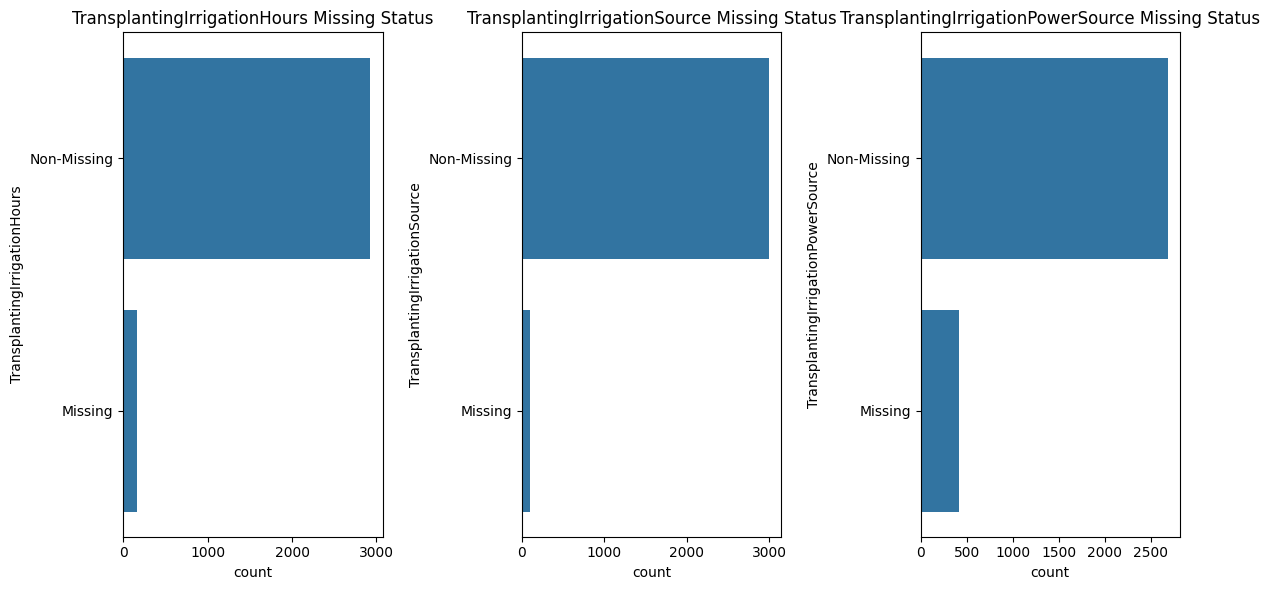

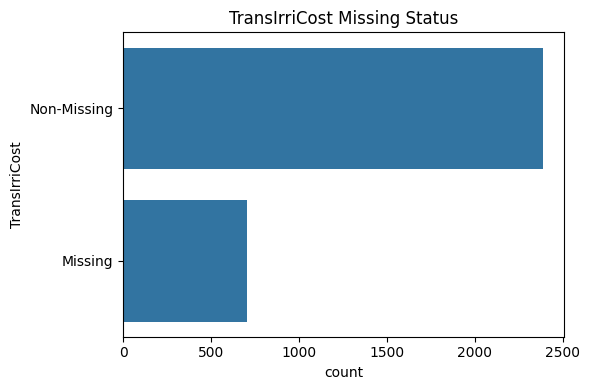

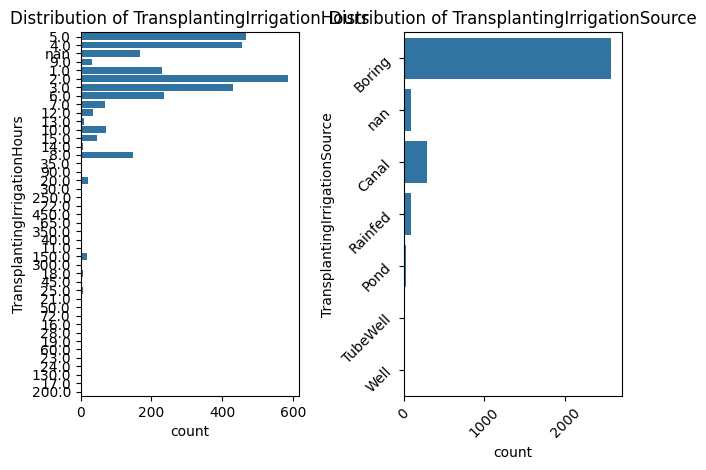

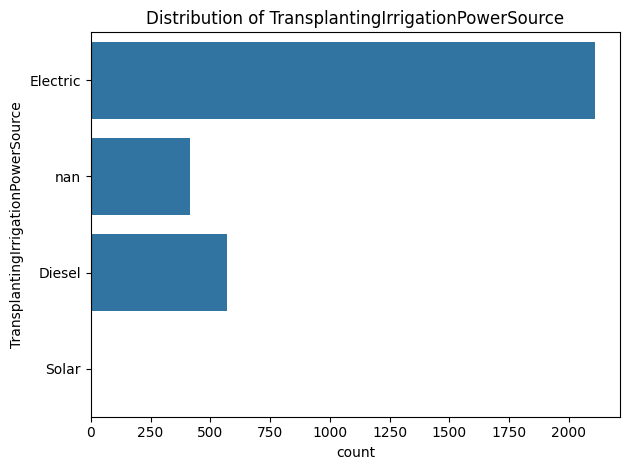

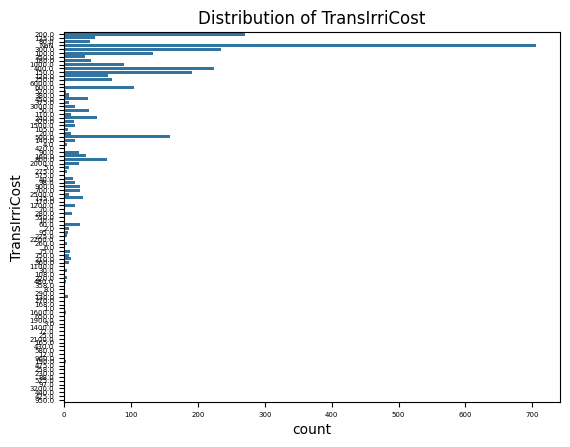

In [15]:
# Function to transform column into 'Missing'/'Non-Missing'
def missing_status(column):
    return column.isna().map({True: 'Missing', False: 'Non-Missing'})

# Plot setup
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# TransplantingIrrigationHours
plt.subplot(1, 3, 1)  # Adjust for 3 subplots
sns.countplot(y=missing_status(dataset['TransplantingIrrigationHours']))
plt.title('TransplantingIrrigationHours Missing Status')

# TransplantingIrrigationSource
plt.subplot(1, 3, 2)
sns.countplot(y=missing_status(dataset['TransplantingIrrigationSource']))
plt.title('TransplantingIrrigationSource Missing Status')

# TransplantingIrrigationPowerSource
plt.subplot(1, 3, 3)
sns.countplot(y=missing_status(dataset['TransplantingIrrigationPowerSource']))
plt.title('TransplantingIrrigationPowerSource Missing Status')

# Adjustments
plt.tight_layout()
plt.show()

# Separate plot for TransIrriCost
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.countplot(y=missing_status(dataset['TransIrriCost']))
plt.title('TransIrriCost Missing Status')

# Adjustments
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
sns.countplot(data = dataset, y = dataset['TransplantingIrrigationHours'].fillna('nan'))
plt.title('Distribution of TransplantingIrrigationHours')

plt.subplot(1, 2, 2)
sns.countplot(data = dataset, y = dataset['TransplantingIrrigationSource'].fillna('nan'))
plt.title('Distribution of TransplantingIrrigationSource')

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.tight_layout()
plt.show()

plt.subplot(1, 1, 1)
sns.countplot(data = dataset, y = dataset['TransplantingIrrigationPowerSource'].fillna('nan'))
plt.title('Distribution of TransplantingIrrigationPowerSource')

plt.tight_layout()
plt.show()

plt.subplot(1, 1, 1)
sns.countplot(data = dataset.fillna(False), y = dataset['TransIrriCost'].fillna('NaN'))
plt.title('Distribution of TransIrriCost')

plt.xticks(size=5)
plt.yticks(size=5)

plt.show()

A big and boring code chunk to deal with the missing value

In [16]:
# Filtering the dataset to include rows where 'TransplantingIrrigationHours' is not zero

df_non_zero_irrigation = dataset[dataset['TransplantingIrrigationHours'] != 0]
df_test_non_zero_irrigation = dataset_test[dataset_test['TransplantingIrrigationHours'] != 0]

# Checking how many unique combinations exist for 'TransplantingIrrigationSource' and 'TransplantingIrrigationPowerSource'
unique_combinations = df_non_zero_irrigation.groupby(['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource']).size().reset_index(name='Count')
unique_combinations_test = df_test_non_zero_irrigation.groupby(['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource']).size().reset_index(name='Count')
unique_combinations_count = unique_combinations.shape[0]
unique_combinations_count_test = unique_combinations_test.shape[0]

# Calculating the average 'TransIrriCost' for each group
avg_cost_by_group = df_non_zero_irrigation.groupby(['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource'])['TransIrriCost'].mean().reset_index()
avg_cost_by_group_test = df_test_non_zero_irrigation.groupby(['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource'])['TransIrriCost'].mean().reset_index()

# Merging the average cost back to the original dataframe to fill missing values
# We will perform a left join on the original dataframe with the average cost dataframe based on the two groupby columns
dataset = dataset.merge(avg_cost_by_group, how='left', on=['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource'], suffixes=('', '_avg'))
dataset_test = dataset_test.merge(avg_cost_by_group_test, how='left', on=['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource'], suffixes=('', '_avg'))

# Now we fill the missing 'TransIrriCost' values where 'TransplantingIrrigationHours' is not zero
# with the corresponding average cost from the same group
mask = (dataset['TransplantingIrrigationHours'] != 0) & (dataset['TransIrriCost'].isnull())
dataset.loc[mask, 'TransIrriCost'] = dataset.loc[mask, 'TransIrriCost_avg']
mask_test = (dataset_test['TransplantingIrrigationHours'] != 0) & (dataset_test['TransIrriCost'].isnull())
dataset_test.loc[mask_test, 'TransIrriCost'] = dataset_test.loc[mask_test, 'TransIrriCost_avg']

dataset.drop('TransIrriCost_avg', axis=1, inplace=True)
dataset_test.drop('TransIrriCost_avg', axis=1, inplace=True)

# Filling in 'TransIrriCost' with 0 where 'TransplantingIrrigationHours' is 0
dataset.loc[dataset['TransplantingIrrigationHours'] == 0, 'TransIrriCost'] = 0
dataset_test.loc[dataset_test['TransplantingIrrigationHours'] == 0, 'TransIrriCost'] = 0

# Find the mode of 'TransplantingIrrigationSource' for each 'CropEstMethod'
irrigation_source_mode = dataset.groupby('CropEstMethod')['TransplantingIrrigationSource'].agg(pd.Series.mode).reset_index()
irrigation_test_source_mode = dataset_test.groupby('CropEstMethod')['TransplantingIrrigationSource'].agg(pd.Series.mode).reset_index()

# There can be more than one mode in a set of values, so we ensure to have a single value by picking the first one
irrigation_source_mode['TransplantingIrrigationSource'] = irrigation_source_mode['TransplantingIrrigationSource'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)
irrigation_test_source_mode['TransplantingIrrigationSource'] = irrigation_test_source_mode['TransplantingIrrigationSource'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)

# Create a dictionary for mapping 'CropEstMethod' to the mode of 'TransplantingIrrigationSource'
irrigation_source_map = dict(zip(irrigation_source_mode['CropEstMethod'], irrigation_source_mode['TransplantingIrrigationSource']))
irrigation_test_source_map = dict(zip(irrigation_test_source_mode['CropEstMethod'], irrigation_test_source_mode['TransplantingIrrigationSource']))

# Fill missing 'TransplantingIrrigationSource' values based on the 'CropEstMethod' they correspond to
dataset['TransplantingIrrigationSource'] = dataset.apply(
    lambda row: irrigation_source_map[row['CropEstMethod']] if pd.isnull(row['TransplantingIrrigationSource']) else row['TransplantingIrrigationSource'],
    axis=1
)
dataset_test['TransplantingIrrigationSource'] = dataset_test.apply(
    lambda row: irrigation_test_source_map[row['CropEstMethod']] if pd.isnull(row['TransplantingIrrigationSource']) else row['TransplantingIrrigationSource'],
    axis=1
)

# Next, we fill in the missing values for 'TransplantingIrrigationPowerSource' in a similar fashion
power_source_mode = dataset.groupby('CropEstMethod')['TransplantingIrrigationPowerSource'].agg(pd.Series.mode).reset_index()
power_source_test_mode = dataset_test.groupby('CropEstMethod')['TransplantingIrrigationPowerSource'].agg(pd.Series.mode).reset_index()
power_source_mode['TransplantingIrrigationPowerSource'] = power_source_mode['TransplantingIrrigationPowerSource'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)
power_source_map = dict(zip(power_source_mode['CropEstMethod'], power_source_mode['TransplantingIrrigationPowerSource']))
dataset['TransplantingIrrigationPowerSource'] = dataset.apply(
    lambda row: power_source_map[row['CropEstMethod']] if pd.isnull(row['TransplantingIrrigationPowerSource']) else row['TransplantingIrrigationPowerSource'],
    axis=1
)
power_source_test_mode['TransplantingIrrigationPowerSource'] = power_source_test_mode['TransplantingIrrigationPowerSource'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)
power_source_test_map = dict(zip(power_source_test_mode['CropEstMethod'], power_source_test_mode['TransplantingIrrigationPowerSource']))
dataset_test['TransplantingIrrigationPowerSource'] = dataset_test.apply(
    lambda row: power_source_test_map[row['CropEstMethod']] if pd.isnull(row['TransplantingIrrigationPowerSource']) else row['TransplantingIrrigationPowerSource'],
    axis=1
)

# Now, we recalculate the average 'TransIrriCost' for each group of 'TransplantingIrrigationSource' and 'TransplantingIrrigationPowerSource'
avg_cost_by_group = dataset.groupby(['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource'])['TransIrriCost'].mean().reset_index()
dataset = dataset.merge(avg_cost_by_group, how='left', on=['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource'], suffixes=('', '_avg'))
avr_cost_by_group_test = dataset_test.groupby(['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource'])['TransIrriCost'].mean().reset_index()
dataset_test = dataset_test.merge(avr_cost_by_group_test, how='left', on=['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource'], suffixes=('', '_avg'))

# Fill the missing 'TransIrriCost' values again
mask = (dataset['TransplantingIrrigationHours'] != 0) & (dataset['TransIrriCost'].isnull())
dataset.loc[mask, 'TransIrriCost'] = dataset.loc[mask, 'TransIrriCost_avg']
dataset.drop('TransIrriCost_avg', axis=1, inplace=True)
mask_test = (dataset_test['TransplantingIrrigationHours'] != 0) & (dataset_test['TransIrriCost'].isnull())
dataset_test.loc[mask_test, 'TransIrriCost'] = dataset_test.loc[mask_test, 'TransIrriCost_avg']
dataset_test.drop('TransIrriCost_avg', axis=1, inplace=True)

Visualize the result after the processing, make sure the missing value was processed correctly

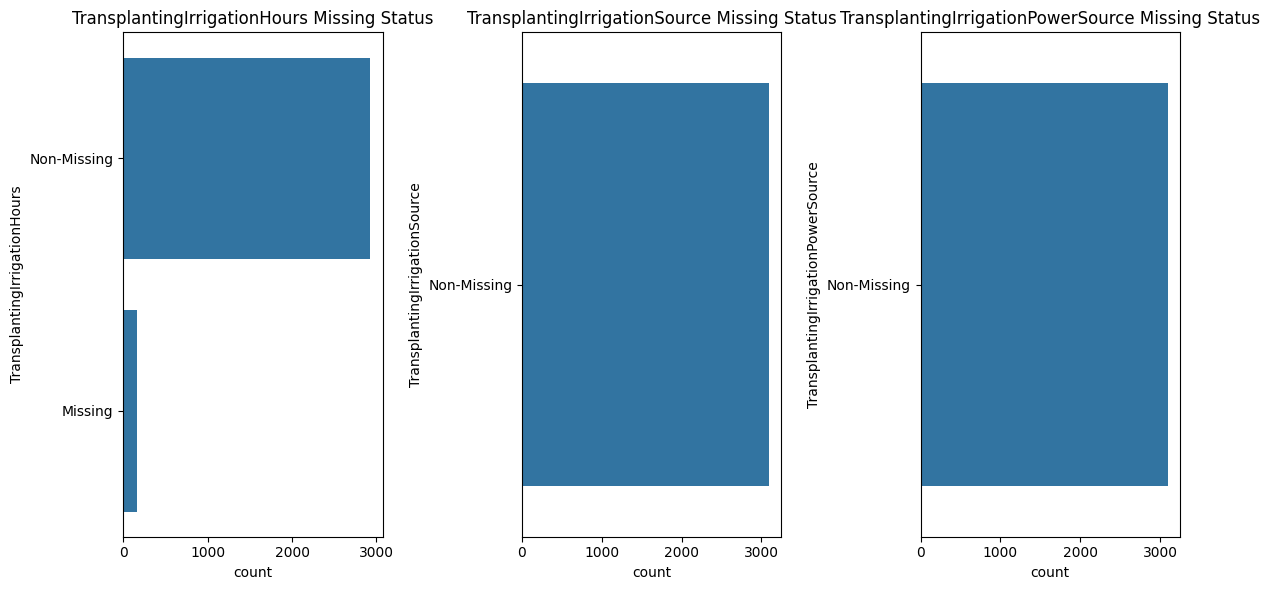

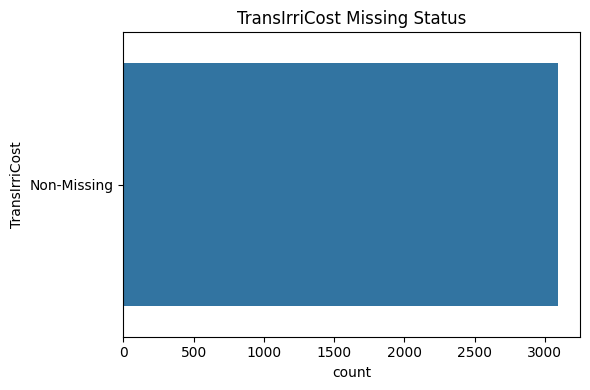

In [17]:
# Visualize the result after we do the preprocessing 
# Plot setup
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# TransplantingIrrigationHours
plt.subplot(1, 3, 1)  # Adjust for 3 subplots
sns.countplot(y=missing_status(dataset['TransplantingIrrigationHours']))
plt.title('TransplantingIrrigationHours Missing Status')

# TransplantingIrrigationSource
plt.subplot(1, 3, 2)
sns.countplot(y=missing_status(dataset['TransplantingIrrigationSource']))
plt.title('TransplantingIrrigationSource Missing Status')

# TransplantingIrrigationPowerSource
plt.subplot(1, 3, 3)
sns.countplot(y=missing_status(dataset['TransplantingIrrigationPowerSource']))
plt.title('TransplantingIrrigationPowerSource Missing Status')

# Adjustments
plt.tight_layout()
plt.show()

# Separate plot for TransIrriCost
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.countplot(y=missing_status(dataset['TransIrriCost']))
plt.title('TransIrriCost Missing Status')

# Adjustments
plt.tight_layout()
plt.show()

Calculate the result again based on this more complicated method

In [19]:
# Calculate if our result improved or not 
X = dataset
y = train_labels 

# Transfer the object datatype into category data
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category').cat.codes
    elif dataset[col].dtype == 'datetime64[ns]':
        dataset = dataset.drop(columns=[col])

for col in dataset_test_copy.columns:
    if dataset_test[col].dtype == 'object':
        dataset_test[col] = dataset_test[col].astype('category').cat.codes
    elif dataset_test[col].dtype == 'datetime64[ns]':
        dataset_test = dataset_test.drop(columns=[col])

categorical_cols = list(categorical_cols)
# print(categorical_cols)

# Parameters
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1024)

# Prepare an array to store the RMSE for each fold
rmse_scores = []
models = []

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X.shape[1])

# Start the K-Fold cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    # Split the data
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Create a LGBMRegressor object
    lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=42)
    
    # Train the model
    lgbm_model.fit(
        X_train_fold, y_train_fold,  
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='mse', 
        categorical_feature=categorical_cols
    )
    
    # Predict on the validation set
    y_pred_val = lgbm_model.predict(X_val_fold, num_iteration=lgbm_model.best_iteration_)

    # Calculate and print RMSE for the current fold
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_scores.append(fold_rmse)
    print(f"Fold {fold}: RMSE: {fold_rmse}")

    # Accumulate feature importances
    feature_importances += lgbm_model.feature_importances_

    models.append(lgbm_model)

# After cross-validation, print the mean RMSE
print(f"Mean RMSE: {np.mean(rmse_scores)}")

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 2476, number of used features: 41
[LightGBM] [Info] Start training from score 566.546446
Fold 0: RMSE: 125.67311978516722
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 2477, number of used features: 41
[LightGBM] [Info] Start training from score 577.469520
Fold 1: RMSE: 127.90187814763937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

Test the result with the test set

In [20]:
test_predictions = []

for model in models:
    # Make predictions
    test_df = dataset_test[X.columns]
    # print(test_df.shape)
    fold_preds = model.predict(test_df, num_iteration=model.best_iteration_)
    test_predictions.append(fold_preds)


test_predictions = np.column_stack(test_predictions)
y_pred_test = np.mean(test_predictions, axis=1)
test_rmse = np.sqrt(mean_squared_error(test_labels, y_pred_test))
print(f"MSE of the prediction is {test_rmse}")

MSE of the prediction is 120.0620506056504


In [21]:
# Function to transform column into 'Missing'/'Non-Missing'
def missing_status(column):
    return column.isna().map({True: 'Missing', False: 'Non-Missing'})

Dealing with the last group of related columns missingf datas

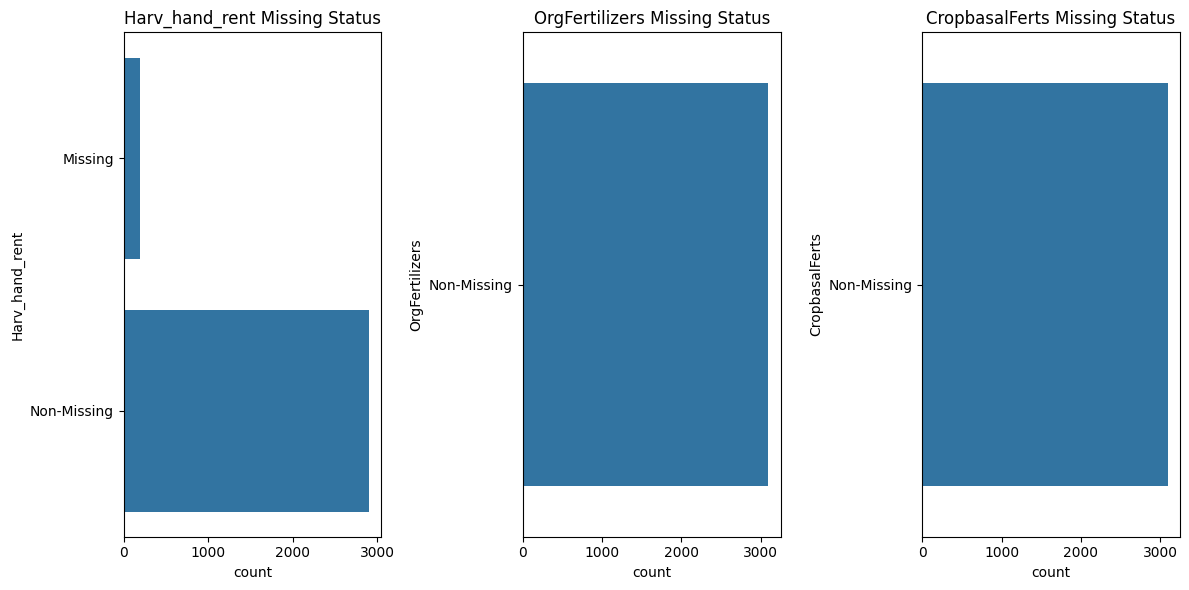

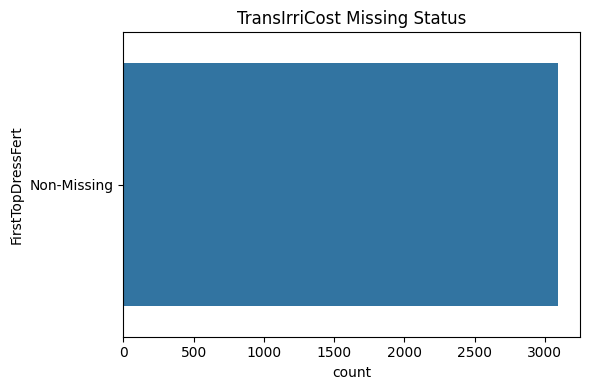

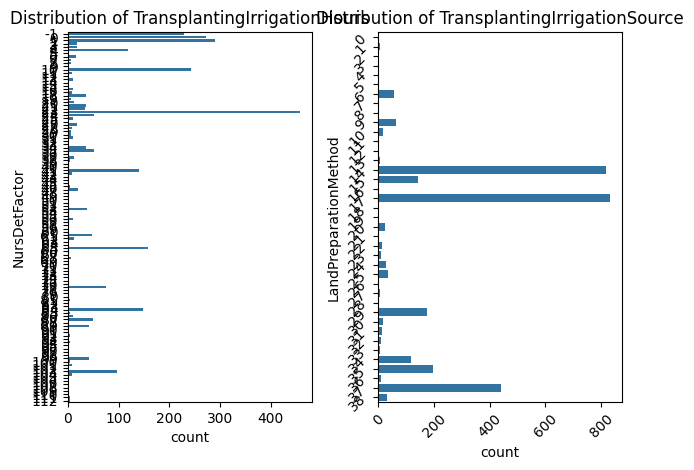

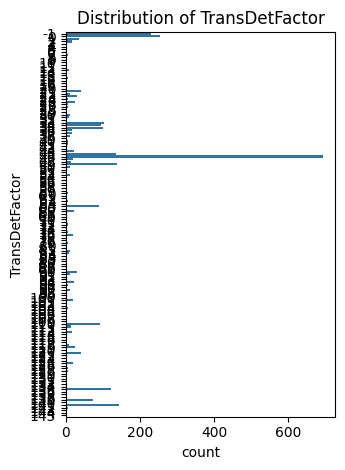

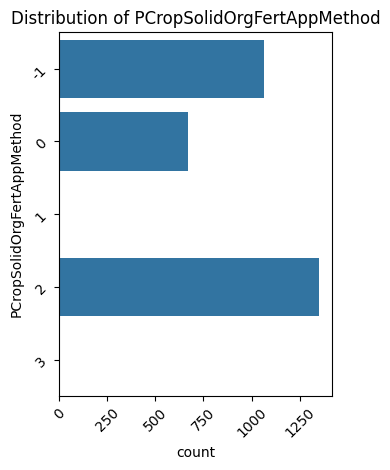

In [22]:
# Plot setup
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# TransplantingIrrigationHours
plt.subplot(1, 3, 1)  # Adjust for 3 subplots
sns.countplot(y=missing_status(dataset['Harv_hand_rent']))
plt.title('Harv_hand_rent Missing Status')

# TransplantingIrrigationSource
plt.subplot(1, 3, 2)
sns.countplot(y=missing_status(dataset['OrgFertilizers']))
plt.title('OrgFertilizers Missing Status')

# TransplantingIrrigationPowerSource
plt.subplot(1, 3, 3)
sns.countplot(y=missing_status(dataset['CropbasalFerts']))
plt.title('CropbasalFerts Missing Status')

# Adjustments
plt.tight_layout()
plt.show()

# Separate plot for TransIrriCost
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.countplot(y=missing_status(dataset['FirstTopDressFert']))
plt.title('TransIrriCost Missing Status')

# Adjustments
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
sns.countplot(data = dataset, y = dataset['NursDetFactor'].fillna('nan'))
plt.title('Distribution of TransplantingIrrigationHours')

plt.subplot(1, 2, 2)
sns.countplot(data = dataset, y = dataset['LandPreparationMethod'].fillna('nan'))
plt.title('Distribution of TransplantingIrrigationSource')

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
sns.countplot(data = dataset, y = dataset['TransDetFactor'].fillna('nan'))
plt.title('Distribution of TransDetFactor')

plt.tight_layout()
plt.show()

plt.subplot(1, 2, 2)
sns.countplot(data = dataset.fillna(False), y = dataset['PCropSolidOrgFertAppMethod'].fillna('NaN'))
plt.title('Distribution of PCropSolidOrgFertAppMethod')

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.tight_layout()
plt.savefig('Distribution of TransDetFactor_and_PCrop.png')
plt.show()
plt.close()

In [23]:
dataset['Harv_hand_rent'] = dataset['Harv_hand_rent'].fillna(0)
dataset['OrgFertilizers'] = dataset['OrgFertilizers'].fillna('None')
dataset['CropbasalFerts'] = dataset['CropbasalFerts'].fillna('None')
dataset['FirstTopDressFert'] = dataset['FirstTopDressFert'].fillna('None')
dataset['NursDetFactor'] = dataset['NursDetFactor'].fillna('None')
dataset['LandPreparationMethod'] = dataset['LandPreparationMethod'].fillna('None')
dataset['TransDetFactor'] = dataset['TransDetFactor'].fillna(dataset['TransDetFactor'].mode()[0])
dataset['PCropSolidOrgFertAppMethod'] = dataset['PCropSolidOrgFertAppMethod'].fillna('None')

dataset_test['Harv_hand_rent'] = dataset_test['Harv_hand_rent'].fillna(0)
dataset_test['OrgFertilizers'] = dataset_test['OrgFertilizers'].fillna('None')
dataset_test['CropbasalFerts'] = dataset_test['CropbasalFerts'].fillna('None')
dataset_test['FirstTopDressFert'] = dataset_test['FirstTopDressFert'].fillna('None')
dataset_test['NursDetFactor'] = dataset_test['NursDetFactor'].fillna('None')
dataset_test['LandPreparationMethod'] = dataset_test['LandPreparationMethod'].fillna('None')
dataset_test['TransDetFactor'] = dataset_test['TransDetFactor'].fillna(dataset_test['TransDetFactor'].mode()[0])
dataset_test['PCropSolidOrgFertAppMethod'] = dataset_test['PCropSolidOrgFertAppMethod'].fillna('None')

Checking the sparsity inside the dataset, we manually define columns with more than 30 classes as a 'sparse class'

In [24]:
# Checking the unique values for categorical variables to identify sparse classes
categorical_columns = dataset.select_dtypes(include=['object']).columns
sparse_classes = {col: dataset[col].nunique() for col in categorical_columns if dataset[col].nunique() > 30} 

To deal with the sparsity, we will merge some classes into other classes

In [ ]:
# Define a threshold for grouping
threshold_percentage = 1
threshold = len(dataset) * (threshold_percentage / 100)

# Function to group sparse classes
def group_sparse_classes(df, column, threshold):
    # Find the categories that are below the threshold
    value_counts = df[column].value_counts()
    to_replace = value_counts[value_counts <= threshold].index.tolist()
    
    # Replace the sparse classes with 'other'
    df[column] = df[column].replace(to_replace, 'other')
    return df

# useless_columns = ['TransDetFactor', 'NursDetFactor'], this will be only useful later

# Apply grouping for the identified categorical variables with many unique values
for col in ['LandPreparationMethod', 'OrgFertilizers', 'CropbasalFerts']:
    dataset = group_sparse_classes(dataset, col, threshold)

# Check the new number of unique values for the grouped columns
grouped_classes = {col: dataset[col].nunique() for col in ['LandPreparationMethod', 'OrgFertilizers', 'CropbasalFerts']}

# Adjust the function to use the categories from the training dataset
def adjust_test_categories(train_df, test_df, column):
    # Get the categories in the training data
    train_categories = set(train_df[column].unique())
    # Define a function to apply the adjustment
    def adjust_category(cat):
        return cat if cat in train_categories else 'other'
    # Adjust the test data
    test_df[column] = test_df[column].apply(adjust_category)
    return test_df

# Apply the category adjustment to the test dataset based on the training dataset categories
for col in ['LandPreparationMethod', 'OrgFertilizers', 'CropbasalFerts']:
    test_dataset = adjust_test_categories(dataset, dataset_test, col)
### The TransIrriCost should be connected with TransplantingIrrigationSource, if there is no method used, 
### then it should be 0, otherwise maybe try to use the mean value to fill the missing value for each method

Check the skewness inside the data

In [ ]:
high_skewed_features = ['Residue_perc', 'StandingWater']
# TOOOOOODOOOO, the log2, log10 will be tested 
low_skewed_features = ['Residue_length', 'CropOrgFYM', 'SeedlingsPerPit'] # No missing value here
moderate_skewed_features = ['BasalDAP', 'Acre', 
                            'TransIrriCost', 'Ganaura',
                            'BasalUrea', 'TransplantingIrrigationHours']

In [4]:
# Save the 'Yield' column and drop it
# Load the test dataset
path = 'Train.csv'
dataset = pd.read_csv(path)
train_labels = dataset['Yield'].copy()
dataset = dataset.drop(columns=['ID','Yield'], axis = 1)
ID = dataset_test['ID'].copy()
dataset_test = dataset_test.drop(columns=['ID'], axis = 1)

# Load the test dataset
test_path = 'Test.csv'
dataset_test = pd.read_csv(test_path)
dataset_upload = dataset_test.copy()
dataset_test = dataset_test.drop(columns=['ID'], axis=1)

In [ ]:
# Read the dataset
path = 'Train.csv'
dataset = pd.read_csv(path)
train_labels = dataset['Yield'].copy()
dataset = dataset.drop(columns=['ID','Yield'], axis=1)

In [5]:
dataset['Harv_hand_rent'] = dataset['Harv_hand_rent'].fillna(0)
dataset['OrgFertilizers'] = dataset['OrgFertilizers'].fillna(dataset['OrgFertilizers'].mode()[0])
dataset['CropbasalFerts'] = dataset['CropbasalFerts'].fillna(dataset['CropbasalFerts'].mode()[0])
dataset['FirstTopDressFert'] = dataset['FirstTopDressFert'].fillna(dataset['FirstTopDressFert'].mode()[0])
dataset['NursDetFactor'] = dataset['NursDetFactor'].fillna(dataset['NursDetFactor'].mode()[0])
dataset['LandPreparationMethod'] = dataset['LandPreparationMethod'].fillna(dataset['LandPreparationMethod'].mode()[0])
dataset['TransDetFactor'] = dataset['TransDetFactor'].fillna(dataset['TransDetFactor'].mode()[0])
dataset['PCropSolidOrgFertAppMethod'] = dataset['PCropSolidOrgFertAppMethod'].fillna(dataset['PCropSolidOrgFertAppMethod'].mode()[0])

dataset_test['Harv_hand_rent'] = dataset_test['Harv_hand_rent'].fillna(0)
dataset_test['OrgFertilizers'] = dataset_test['OrgFertilizers'].fillna(dataset_test['OrgFertilizers'].mode()[0])
dataset_test['CropbasalFerts'] = dataset_test['CropbasalFerts'].fillna(dataset_test['CropbasalFerts'].mode()[0])
dataset_test['FirstTopDressFert'] = dataset_test['FirstTopDressFert'].fillna(dataset_test['FirstTopDressFert'].mode()[0])
dataset_test['NursDetFactor'] = dataset_test['NursDetFactor'].fillna(dataset_test['NursDetFactor'].mode()[0])
dataset_test['LandPreparationMethod'] = dataset_test['LandPreparationMethod'].fillna(dataset_test['LandPreparationMethod'].mode()[0])
dataset_test['TransDetFactor'] = dataset_test['TransDetFactor'].fillna(dataset_test['TransDetFactor'].mode()[0])
dataset_test['PCropSolidOrgFertAppMethod'] = dataset_test['PCropSolidOrgFertAppMethod'].fillna(dataset_test['PCropSolidOrgFertAppMethod'].mode()[0])

In [6]:
# Checking the unique values for categorical variables to identify sparse classes
categorical_columns = dataset.select_dtypes(include=['object']).columns
sparse_classes = {col: dataset[col].nunique() for col in categorical_columns if dataset[col].nunique() > 15} 

In [7]:
# check the name of sparse classes
print(sparse_classes.keys())

dict_keys(['LandPreparationMethod', 'CropTillageDate', 'RcNursEstDate', 'SeedingSowingTransplanting', 'NursDetFactor', 'TransDetFactor', 'OrgFertilizers', 'CropbasalFerts', 'Harv_date', 'Threshing_date'])


In [8]:
# check the unique values of sparse classes
print(sparse_classes.values())

dict_values([43, 78, 61, 62, 125, 155, 31, 34, 107, 162])


In [9]:
# Define a threshold for grouping
threshold_percentage = 1
threshold = len(dataset) * (threshold_percentage / 100)

In [10]:
# Function to group sparse classes
def group_sparse_classes(df, column, threshold):
    # Find the categories that are below the threshold
    value_counts = df[column].value_counts()
    to_replace = value_counts[value_counts <= threshold].index.tolist()
    
    # Replace the sparse classes with 'other'
    df[column] = df[column].replace(to_replace, 'other')
    return df

In [11]:
# Apply grouping for the identified categorical variables with many unique values
for col in ['LandPreparationMethod', 'OrgFertilizers', 'CropbasalFerts']:
    dataset = group_sparse_classes(dataset, col, threshold)

In [12]:
# Apply the category adjustment to the test dataset based on the training dataset categories
for col in ['LandPreparationMethod', 'OrgFertilizers', 'CropbasalFerts']:
    test_dataset = group_sparse_classes(dataset_test, col, threshold)

In [13]:
# fill the high skewness columns with median
# check the skewness of the numerical columns
skewness = dataset.skew(numeric_only=True)
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# sort the skewness in descending order
skewness.sort_values(ascending=False)
print(skewness)

There are 18 skewed numerical features to Box Cox transform
CultLand                         8.178796
CropCultLand                     8.796317
SeedlingsPerPit                 53.528364
TransplantingIrrigationHours    30.754264
TransIrriCost                    3.912326
StandingWater                    1.848641
Ganaura                          5.237242
CropOrgFYM                       6.876849
BasalDAP                         2.905715
BasalUrea                        2.244465
1tdUrea                          2.094479
1appDaysUrea                     4.769872
2tdUrea                          2.696580
2appDaysUrea                    -1.589283
Harv_hand_rent                  40.547049
Residue_length                  -1.880371
Residue_perc                     3.747956
Acre                             2.384037
dtype: float64


In [14]:
high_skewed_features = ['SeedlingsPerPit', 'TransplantingIrrigationHours','Harv_hand_rent']
low_skewed_features = ['CultLand', 'CropOrgFYM', 'CropCultLand','Ganaura'] 
moderate_skewed_features = ['BasalUrea', 'BasalDAP',
                            '1tdUrea', '1appDaysUrea', 
                            '2tdUrea', '2appDaysUrea',
                            'Residue_length', 'Residue_perc',
                            'StandingWater', 'TransIrriCost',
                            'TransIrriCost']

In [15]:
# check the dtype of those skewed features
print(dataset[high_skewed_features].dtypes)
print(dataset[low_skewed_features].dtypes)
print(dataset[moderate_skewed_features].dtypes)

SeedlingsPerPit                 float64
TransplantingIrrigationHours    float64
Harv_hand_rent                  float64
dtype: object
CultLand          int64
CropOrgFYM      float64
CropCultLand      int64
Ganaura         float64
dtype: object
BasalUrea         float64
BasalDAP          float64
1tdUrea           float64
1appDaysUrea      float64
2tdUrea           float64
2appDaysUrea      float64
Residue_length      int64
Residue_perc        int64
StandingWater     float64
TransIrriCost     float64
TransIrriCost     float64
dtype: object


In [16]:
# Fill the low skewness columns with mean
for feat in low_skewed_features:
    dataset[feat] = dataset[feat].fillna(dataset[feat].mean())
    dataset_test[feat] = dataset_test[feat].fillna(dataset_test[feat].mean())

# Fill the moderate skewness columns with median
for feat in moderate_skewed_features:
    dataset[feat] = dataset[feat].fillna(dataset[feat].median())
    dataset_test[feat] = dataset_test[feat].fillna(dataset_test[feat].median())

# Fill the high skewness columns with median
for feat in high_skewed_features:
    dataset[feat] = dataset[feat].fillna(dataset[feat].median())
    dataset_test[feat] = dataset_test[feat].fillna(dataset_test[feat].median())

In [17]:
"""
skewed_features = skewness.index
lam = 0.15
# apply the boxcox1p transformation to the skewed features
for feat in skewed_features:
    dataset[feat] = boxcox1p(dataset[feat], lam)
    dataset_test[feat] = boxcox1p(dataset_test[feat], lam)

# check the skewness of the numerical columns
skewness = dataset.skew(numeric_only=True)
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
"""

'\nskewed_features = skewness.index\nlam = 0.15\n# apply the boxcox1p transformation to the skewed features\nfor feat in skewed_features:\n    dataset[feat] = boxcox1p(dataset[feat], lam)\n    dataset_test[feat] = boxcox1p(dataset_test[feat], lam)\n\n# check the skewness of the numerical columns\nskewness = dataset.skew(numeric_only=True)\nskewness = skewness[abs(skewness) > 0.5]\nprint("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))\n'

In [18]:
"""
bins_SeedlingsPerPit = [0, 2, 4, np.inf]
labels_SeedlingsPerPit = ['Low', 'Medium', 'High']
dataset['SeedlingsPerPit_Binned'] = pd.cut(dataset['SeedlingsPerPit'], bins=bins_SeedlingsPerPit, labels=labels_SeedlingsPerPit)
dataset_test['SeedlingsPerPit_Binned'] = pd.cut(dataset_test['SeedlingsPerPit'], bins=bins_SeedlingsPerPit, labels=labels_SeedlingsPerPit)
"""

"\nbins_SeedlingsPerPit = [0, 2, 4, np.inf]\nlabels_SeedlingsPerPit = ['Low', 'Medium', 'High']\ndataset['SeedlingsPerPit_Binned'] = pd.cut(dataset['SeedlingsPerPit'], bins=bins_SeedlingsPerPit, labels=labels_SeedlingsPerPit)\ndataset_test['SeedlingsPerPit_Binned'] = pd.cut(dataset_test['SeedlingsPerPit'], bins=bins_SeedlingsPerPit, labels=labels_SeedlingsPerPit)\n"

In [19]:
"""
bins_NoFertilizerAppln = [0, 1, 2, np.inf]
labels_NoFertilizerAppln = ['Low', 'Medium', 'High']
dataset['NoFertilizerAppln_Binned'] = pd.cut(dataset['NoFertilizerAppln'], bins=bins_NoFertilizerAppln, labels=labels_NoFertilizerAppln)
dataset_test['NoFertilizerAppln_Binned'] = pd.cut(dataset_test['NoFertilizerAppln'], bins=bins_NoFertilizerAppln, labels=labels_NoFertilizerAppln)
"""

"\nbins_NoFertilizerAppln = [0, 1, 2, np.inf]\nlabels_NoFertilizerAppln = ['Low', 'Medium', 'High']\ndataset['NoFertilizerAppln_Binned'] = pd.cut(dataset['NoFertilizerAppln'], bins=bins_NoFertilizerAppln, labels=labels_NoFertilizerAppln)\ndataset_test['NoFertilizerAppln_Binned'] = pd.cut(dataset_test['NoFertilizerAppln'], bins=bins_NoFertilizerAppln, labels=labels_NoFertilizerAppln)\n"

In [20]:
# if RcNursEstDate is NaN, then fill NursDetFactor with None
# if RcNursEstDate is not NaN, then fill NursDetFactor with mode
dataset.loc[dataset['RcNursEstDate'].isnull(), 'NursDetFactor'] = 'None'
dataset.loc[dataset['RcNursEstDate'].notnull(), 'NursDetFactor'] = dataset['NursDetFactor'].mode()[0]

dataset_test.loc[dataset_test['RcNursEstDate'].isnull(), 'NursDetFactor'] = 'None'
dataset_test.loc[dataset_test['RcNursEstDate'].notnull(), 'NursDetFactor'] = dataset_test['NursDetFactor'].mode()[0]

In [21]:
# Fill the missing value with MineralFertAppMethod.1 with mode
dataset['MineralFertAppMethod.1'] = dataset['MineralFertAppMethod.1'].fillna(dataset['MineralFertAppMethod.1'].mode()[0])
dataset_test['MineralFertAppMethod.1'] = dataset_test['MineralFertAppMethod.1'].fillna(dataset_test['MineralFertAppMethod.1'].mode()[0])

In [22]:
# date columns
date_columns = ['Harv_date', 'SeedingSowingTransplanting', 'RcNursEstDate', 'Threshing_date', 'CropTillageDate']

# fill the missing values with mode
for col in date_columns:
    dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
    dataset_test[col] = dataset_test[col].fillna(dataset_test[col].mode()[0])

In [23]:
# convert the date columns to datetime
for col in date_columns:
    dataset[col] = pd.to_datetime(dataset[col])
    dataset_test[col] = pd.to_datetime(dataset_test[col])

In [24]:
dataset['Harv_date_RcNursEstDate'] = (dataset['Harv_date'] - dataset['RcNursEstDate']).dt.days
dataset_test['Harv_date_RcNursEstDate'] = (dataset_test['Harv_date'] - dataset_test['RcNursEstDate']).dt.days
dataset.loc[dataset['Harv_date_RcNursEstDate'] < 0, 'Harv_date_RcNursEstDate'] = dataset.loc[dataset['Harv_date_RcNursEstDate'] < 0, 'Harv_date_RcNursEstDate'] + 365
dataset_test.loc[dataset_test['Harv_date_RcNursEstDate'] < 0, 'Harv_date_RcNursEstDate'] = dataset_test.loc[dataset_test['Harv_date_RcNursEstDate'] < 0, 'Harv_date_RcNursEstDate'] + 365

In [25]:
# Harvest_date - CropTillageDate
dataset['CropTillageDate'] = pd.to_datetime(dataset['CropTillageDate'])
dataset_test['CropTillageDate'] = pd.to_datetime(dataset_test['CropTillageDate'])
dataset['Harv_date_CropTillageDate'] = (dataset['Harv_date'] - dataset['CropTillageDate']).dt.days
dataset_test['Harv_date_CropTillageDate'] = (dataset_test['Harv_date'] - dataset_test['CropTillageDate']).dt.days

In [26]:
# Threshing_date - Harvest_date
dataset['Threshing_date'] = pd.to_datetime(dataset['Threshing_date'])
dataset['Threshing_date_Harv_date'] = (dataset['Threshing_date'] - dataset['Harv_date']).dt.days
dataset_test['Threshing_date'] = pd.to_datetime(dataset_test['Threshing_date'])
dataset_test['Threshing_date_Harv_date'] = (dataset_test['Threshing_date'] - dataset_test['Harv_date']).dt.days

In [27]:
# Generate the month features, this will be transfered into one-hot encoding later
dataset['Harv_date_Month'] = dataset['Harv_date'].dt.month
dataset_test['Harv_date_Month'] = dataset_test['Harv_date'].dt.month

In [28]:
# Create a dictionary to map the month values to the season values
month_to_season = {1: 1, 2: 1, 3: 1, 4: 2, 5: 2,
                     6: 2, 7: 3, 8: 3, 9: 3, 10: 4,
                     11: 4, 12: 4}

In [29]:
# Map the month values to the season values
dataset['Harv_date_Season'] = dataset['Harv_date_Month'].map(month_to_season)
dataset_test['Harv_date_Season'] = dataset_test['Harv_date_Month'].map(month_to_season)

In [30]:
dataset = dataset.drop(columns=['Harv_date_Month'], axis=1)
dataset_test = dataset_test.drop(columns=['Harv_date_Month'], axis=1)

In [31]:
# drop the original date columns
dataset = dataset.drop(columns=date_columns, axis=1)
dataset_test = dataset_test.drop(columns=date_columns, axis=1)

In [32]:
dataset['Org_Crop'] = dataset['OrgFertilizers'].astype(str) + " + " + dataset['CropbasalFerts'].astype(str)
dataset_test['Org_Crop'] = dataset_test['OrgFertilizers'].astype(str) + "+" + dataset_test['CropbasalFerts'].astype(str)
dataset['Crop_FirstTop'] = dataset['CropbasalFerts'].astype(str) + "+" + dataset['FirstTopDressFert'].astype(str)
dataset_test['Crop_FirstTop'] = dataset_test['CropbasalFerts'].astype(str) + "+" + dataset_test['FirstTopDressFert'].astype(str)
dataset['Org_FirstTop'] = dataset['OrgFertilizers'].astype(str) + "+" + dataset['FirstTopDressFert'].astype(str)
dataset_test['Org_FirstTop'] = dataset_test['OrgFertilizers'].astype(str) + "+" + dataset_test['FirstTopDressFert'].astype(str)
dataset['PCropSolidOrgFertAppMethod'] = dataset['PCropSolidOrgFertAppMethod'].fillna('other')
dataset_test['PCropSolidOrgFertAppMethod'] = dataset_test['PCropSolidOrgFertAppMethod'].fillna('other')

In [33]:
# drop all those new columns
dataset = dataset.drop(columns=['Org_Crop', 'Crop_FirstTop', 'Org_FirstTop', 'PCropSolidOrgFertAppMethod'], axis=1)
dataset_test = dataset_test.drop(columns=['Org_Crop', 'Crop_FirstTop', 'Org_FirstTop', 'PCropSolidOrgFertAppMethod'], axis=1)

In [34]:
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category').cat.codes

for col in dataset_test.columns:
    if dataset_test[col].dtype == 'object':
        dataset_test[col] = dataset_test[col].astype('category').cat.codes

In [35]:
X = dataset
y = train_labels    

# Train Test split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=200)

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Select the object columns and categorical columns
object_cols = X.select_dtypes(include=['object'])
categorical_cols = X.select_dtypes(include=['category'])
whole_categorical_cols = pd.concat([object_cols, categorical_cols], axis=1) 
# generate a list with the name of the categorical columns
whole_categorical_cols = whole_categorical_cols.columns
# Transfer into a list
whole_categorical_cols = list(whole_categorical_cols)

In [38]:
# Parameters
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=100)

# Prepare an array to store the RMSE for each fold
rmse_scores = []
models = []

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X.shape[1])

# Start the K-Fold cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    # Split the data
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Create a LGBMRegressor object
    lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.01, n_estimators=100)
    
    # Train the model
    lgbm_model.fit(
        X_train_fold, y_train_fold, 
        eval_set=[(X_val_fold, y_val_fold)], 
        eval_metric='mae', 
        categorical_feature=whole_categorical_cols
    )
    
    # Predict on the validation set
    y_pred_val = lgbm_model.predict(X_val_fold, num_iteration=0)

    # Calculate and print RMSE for the current fold
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_scores.append(fold_rmse)
    print(f"Fold {fold}: RMSE: {fold_rmse}")

    # Accumulate feature importances
    feature_importances += lgbm_model.feature_importances_

    models.append(lgbm_model)

# After cross-validation, print the mean RMSE
print(f"Mean RMSE: {np.mean(rmse_scores)}")

# Feature importances from all folds
feature_importances = feature_importances / n_splits
# print(feature_importances)

# Create a dataframe of feature importances
# feature_importances_df = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending=False)

# Print the top 20 features with their importance values
# print(feature_importances_df.head(20))
test_predictions = []

for model in models:
    # Make predictions
    fold_preds = model.predict(dataset_test, num_iteration=model.best_iteration_)
    test_predictions.append(fold_preds)

# Average these predictions
test_predictions = np.column_stack(test_predictions)
y_pred_test = np.mean(test_predictions, axis=1)

submission_df = pd.DataFrame({'ID': ID, 'Yield': y_pred_test})
submission_df.to_csv('result_file/submission_11_22_01.csv', index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 3483, number of used features: 39
[LightGBM] [Info] Start training from score 597.052541
Fold 0: RMSE: 412.15138447901995
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 3483, number of used features: 39
[LightGBM] [Info] Start training from score 593.591444
Fold 1: RMSE: 410.4462386934124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1240
[LightGBM] [Info] Number of data points in the train 

In [ ]:
print(set(dataset_test.columns) - set(X.columns))

In [ ]:
# Initialize a new wandb run
wandb.init(project='zindi-crop-challenge', 
           entity="lmu-seminar")

# Define your hyperparameters
hyperparameters = dict(
    objective='regression',
    num_leaves=31,
    learning_rate=0.009,
    n_estimators=120,
    # Add other hyperparameters you want to track here
)

# Save hyperparameters to wandb
wandb.config.update(hyperparameters)

# Rest of your code for preparing the data
# ...

# Parameters for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=82)

rmse_scores = []
models = []

feature_importances = np.zeros(X_train.shape[1])

# Start the K-Fold cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Create a LGBMRegressor object with hyperparameters from wandb
    lgbm_model = lgb.LGBMRegressor(**wandb.config)
    
    # Train the model
    lgbm_model.fit(
        X_train_fold, y_train_fold, 
        eval_set=[(X_val_fold, y_val_fold)], 
        eval_metric='mae', 
        categorical_feature=whole_categorical_cols,
        callbacks=[wandb.callback()]
    )
    
    # Predict on the validation set
    y_pred_val = lgbm_model.predict(X_val_fold, num_iteration=lgbm_model.best_iteration_)

    # Calculate RMSE and log the metric to wandb
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_scores.append(fold_rmse)
    wandb.log({'fold_rmse': fold_rmse, 'fold': fold})

    # Feature importances
    feature_importances += lgbm_model.feature_importances_

    # Save the model to wandb
    wandb.sklearn.log_model(lgbm_model, 'LGBMRegressor')
    
    models.append(lgbm_model)

# Log mean and standard deviation of RMSE across folds to wandb
wandb.log({'mean_rmse': np.mean(rmse_scores), 'std_rmse': np.std(rmse_scores)})

# Feature importances
feature_importances = feature_importances / n_splits
# You can also log feature importances to wandb here

# Finalize and close your wandb run
wandb.finish()